In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, auc
import seaborn as sns

In [4]:
data_folder = pathlib.Path('./dataset')

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)



Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [20]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

In [21]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

Freezing all layers until the fourth from the last

In [23]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [24]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 180, 180,  │          0 │ input_layer_8[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 180, 180)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 180, 180)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 180, 180)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 180, 180,  │          0 │ get_item_6[0][0], │
│                     │ 3)                │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 180, 180,  │          0 │ stack_2[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 5, 5, 512) │ 14,714,688 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 12800)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │  3,277,056 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        257 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,992,001 (68.63 MB)

 Trainable params: 10,356,737 (39.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [25]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.6362 - loss: 7.3632 - val_accuracy: 0.9190 - val_loss: 0.6486
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 207s 3s/step - accuracy: 0.8374 - loss: 1.1792 - val_accuracy: 0.9450 - val_loss: 0.3199
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step - accuracy: 0.8765 - loss: 0.6932 - val_accuracy: 0.9560 - val_loss: 0.2373
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.9004 - loss: 0.4767 - val_accuracy: 0.9580 - val_loss: 0.2046
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 207s 3s/step - accuracy: 0.9424 - loss: 0.2322 - val_accuracy: 0.9640 - val_loss: 0.2037
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 207s 3s/step - accuracy: 0.9516 - loss: 0.1841 - val_accuracy: 0.9650 - val_loss: 0.1520
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 207s 3s/step - accuracy: 0.9322 - loss: 0.2481 - val_accuracy: 0.9670 - val_loss: 0.1540
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.9521 - loss: 0.1665 - val_accuracy: 0.9640 - v

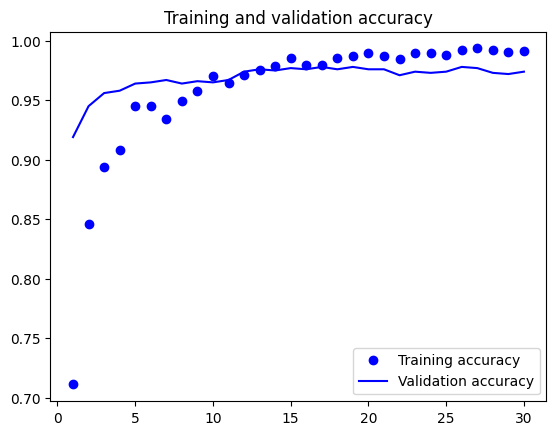

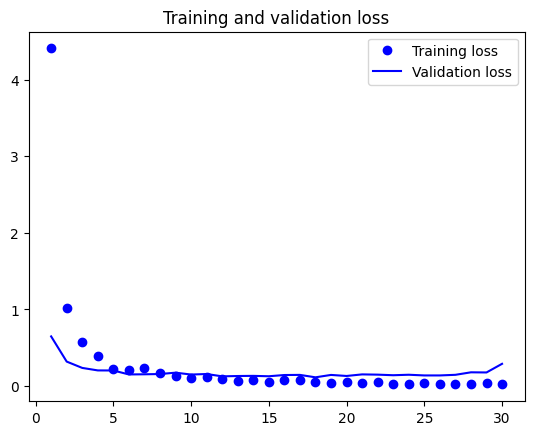

In [26]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [27]:
model = keras.models.load_model("./models/fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9769 - loss: 0.1110
Test accuracy: 0.975


EVALUATE AND COMPARE THE CNN AND VGG16 MODELS

In [7]:
def load_cnn_model():
    cnn_model = keras.models.load_model("./models/convnet_from_scratch_with_augmentation.keras")
    return cnn_model

def load_vgg_model():
    vgg_model = keras.models.load_model("./models/fine_tuning.keras")
    return vgg_model

def get_predictions(model, dataset):
    y_pred_prob = []
    y_true = []
    
    for images, labels in dataset:
        y_pred_prob.extend(model.predict(images))
        y_true.extend(labels.numpy())
    
    y_pred_prob = np.array(y_pred_prob)
    y_true = np.array(y_true)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    return y_true, y_pred, y_pred_prob

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_precision_recall_curve(y_true, y_pred_prob, title):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {title}')
    plt.legend()
    plt.grid(True)
    plt.show()

def analyze_misclassifications(model, dataset, title, num_examples=5):
    misclassified_images = []
    misclassified_pred_probs = []
    true_labels = []
    
    for images, labels in dataset:
        predictions = model.predict(images)
        pred_classes = (predictions > 0.5).astype(int)
        
        for i, (pred, true) in enumerate(zip(pred_classes, labels.numpy())):
            if pred != true:
                misclassified_images.append(images[i])
                misclassified_pred_probs.append(predictions[i][0])
                true_labels.append(true)
                
                if len(misclassified_images) >= num_examples:
                    break
        if len(misclassified_images) >= num_examples:
            break
    
    plt.figure(figsize=(15, 3))
    for i in range(min(num_examples, len(misclassified_images))):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(misclassified_images[i].numpy().astype("uint8"))
        plt.title(f'True: {true_labels[i]}\nPred: {misclassified_pred_probs[i]:.2f}')
        plt.axis('off')
    plt.suptitle(f'Misclassified Examples')
    plt.show()

=== CNN Model Evaluation ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━

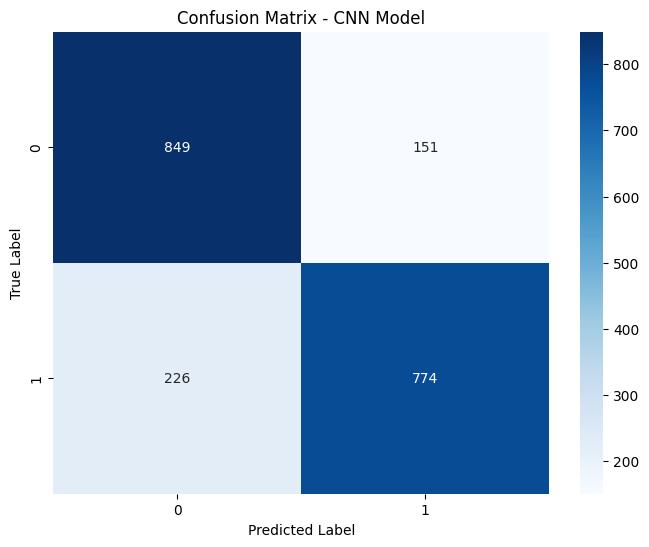

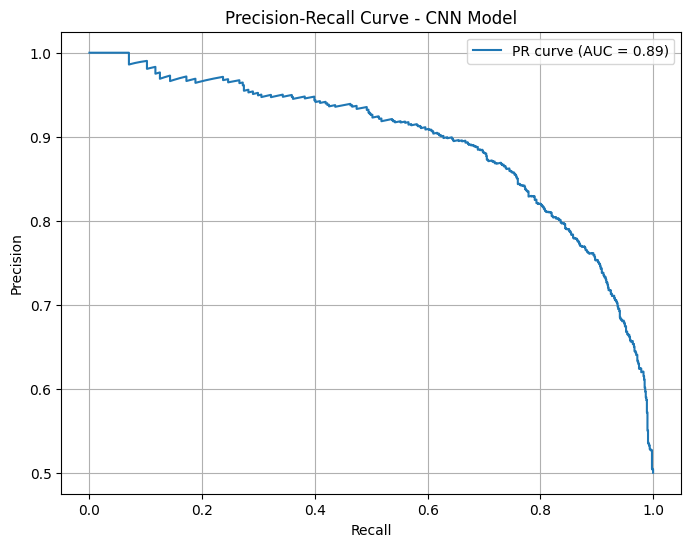

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


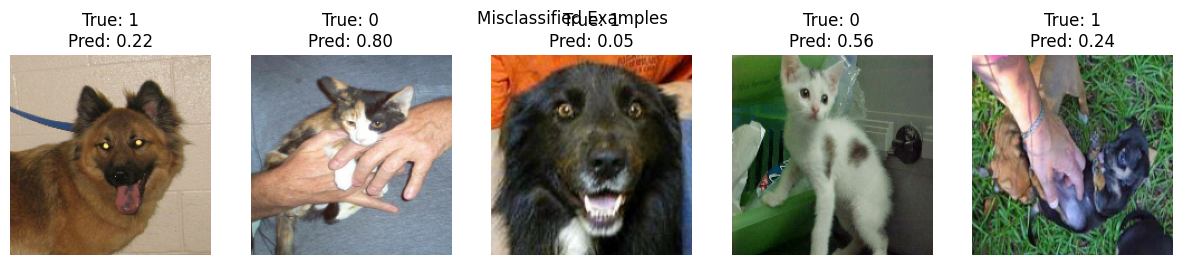

In [ ]:
def evaluate_cnn_model(test_dataset):
    """Main function to evaluate both models"""
    cnn_model = load_cnn_model()
    
    # Evaluate CNN model
    print("=== CNN Model Evaluation ===")
    y_true_cnn, y_pred_cnn, y_pred_prob_cnn = get_predictions(cnn_model, test_dataset)
    print("\nClassification Report:")
    print(classification_report(y_true_cnn, y_pred_cnn))
    plot_confusion_matrix(y_true_cnn, y_pred_cnn, "CNN Model")
    plot_precision_recall_curve(y_true_cnn, y_pred_prob_cnn, "CNN Model")
    analyze_misclassifications(cnn_model, test_dataset, "CNN Model")


evaluate_cnn_model(test_dataset)


=== VGG16 Model Evaluation ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/s

2024-12-02 00:38:05.015293: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


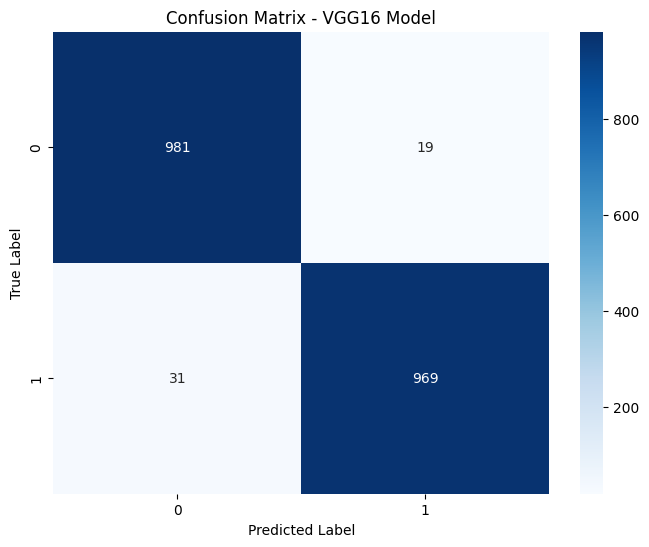

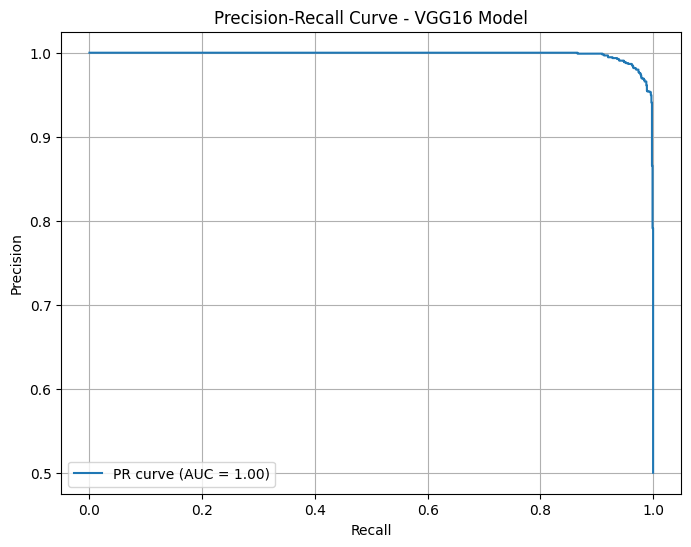

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


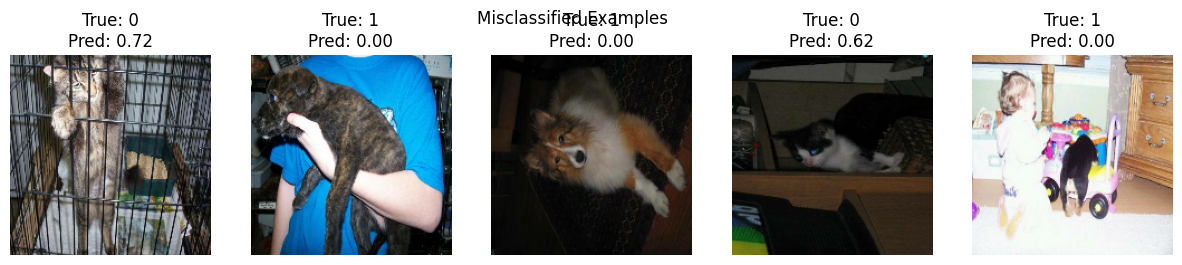

In [11]:
def evaluate_vgg16_model(test_dataset):
    vgg_model = load_vgg_model()
    
    # Evaluate VGG16 model
    print("\n=== VGG16 Model Evaluation ===")
    y_true_vgg, y_pred_vgg, y_pred_prob_vgg = get_predictions(vgg_model, test_dataset)
    print("\nClassification Report:")
    print(classification_report(y_true_vgg, y_pred_vgg))
    plot_confusion_matrix(y_true_vgg, y_pred_vgg, "VGG16 Model")
    plot_precision_recall_curve(y_true_vgg, y_pred_prob_vgg, "VGG16 Model")
    analyze_misclassifications(vgg_model, test_dataset, "VGG16 Model")

evaluate_vgg16_model(test_dataset)

# COMPARISONS AND CONCLUSION

# VGG16

- The model overall provides very reliable performance. with better scores than the custom CNN across the board.

- The model struggles with images taken in poor lighting conditions or contains complex backgrounds

- The VGG16 model would be preferred over the CNN for production use

The VGG16 model comes pre-trained on over a million images, considering our dataset only has 5000 images we would expect it to perform much better than a custom CNN.

The confusion matrix shows a very low number of false positives or negatives, indicating the model has learned to recognize distinctive features for both categories without developing a bias toward either class. Leading to very few cases being misclassified.







# CNN From scratch

The custom CNN, achieves a decent 81% accuracy, but it shows much more limitations in its performance as compared to the fine-tuned vgg16 model.

The confusion matrix reveals a much higher number of misclassifications, with an uneven number of False positives and false negatives (226-151), 

This both indicates a bias in the model, as well as the fact that it has not been able to sufficiently learn the required features

This model generally has lower confidence in it's predictions, with many borderline cases.

Unlike the VGG16 model we can observe it has failed to effectively recognize the features of both classes. Even in cases where there is a simple background with only one subject in the image, we see that the custom CNN has low confidence, and still get's some predictions wrong. Unlike the VGG16 model, which is mostly only hampered by more complex images.


The main reason for the lower performance is the lack of training data. The custom CNN only has 5000 images to work with (not including augmented images). So it's ability to learn the features of both classes is greatly reduced.

# CONCLUSION

- The VGG16 model is able to outperform the CNN from scratch due to its pre-trained nature and deeper architecture,
- This allow it to better generalize across much more varying conditions. 
- While both models show some common failure patterns, VGG16's errors are more acceptable and occur in more genuinely challenging cases, while the CNN's errors occur even in relatively straightforward scenarios.

From our analysis we can determine that the VGG16 is definitely preferred for practical use over the CNN from scratch. It not only makes less mistakes but it also makes more understandable mistakes, that could likely be addressed with further data augmentation or better fine-tuning strategies.